# BlackJack Multi-Armed Bandits: Exploración vs Explotación

### Introducción
La principal diferencia entre el aprendizaje por refuerzo y el resto de métodos de aprendizaje es que durante el entrenamiento un agente aprende a través de la evaluación de las acciones tomadas en vez de ser instruido diciéndole exactamente qué acciones son las correctas (aprendizaje supervisado). Es por este motivo que necesitamos de una exploración activa, de forma que a través de la prueba y el error nuestro agente descubra las mejores acciones para poder explotarlas en el futuro.
### BlackJack como Problema de Bandits
En este notebook vamos a estudiar el aspecto evaluador en su configuración más básica, aplicado al entorno BlackJack de Gymnasium. En lugar del clásico juego Whac-A-Mole del cuadernillo original, utilizaremos BlackJack donde el jugador debe decidir entre dos acciones: STICK (quedarse) o HIT (pedir carta).
El problema se basa en tomar una decisión (acción) de entre dos opciones: ¿qué acción tomar para obtener la máxima recompensa contra el dealer?
### Formulación Matemática
Empezamos definiendo el valor de una acción como la recompensa esperada tras seleccionar dicha acción:


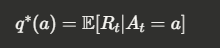

donde $q^*(a)$ es el valor verdadero de la acción $a$, que corresponde a la acción $A_t$ tomada en el instante $t$ y $R_t$ es su recompensa.
Conociendo este valor, el problema se resuelve escogiendo en cada momento aquella acción con mayor valor. El problema es que, a priori, no conocemos este valor, pero podemos aproximarlo. Para ello, definimos $Q_t(a)$ como el valor estimado de la acción $a$ en el instante $t$, cuyo valor queremos que sea tan cercano a $q^*(a)$ como sea posible.
Si en cada instante $t$ llevamos a cabo la acción con un mayor valor estimado, estaremos explotando nuestro conocimiento y es el método adecuado si queremos maximizar la recompensa final. Si elegimos otras acciones con un menor valor estimado, estaremos explorando con el objetivo de encontrar nuevos estados desconocidos con mayor recompensa.
El correcto balance de ambas estrategias es crucial para encontrar soluciones óptimas, pero cualquier método necesita de algún tipo de conocimiento previo sobre el entorno y su comportamiento. Generalmente se prefiere una mayor exploración al principio, cuando el conocimiento del entorno es limitado, que va disminuyendo en favor de una mayor explotación a medida que este conocimiento mejora.

## Configuración del Entorno


### Características del Entorno BlackJack:

Estados: (suma_jugador, carta_visible_dealer, as_usable)

Acciones: 0 = STICK (quedarse), 1 = HIT (pedir carta)

Recompensas: +1 (gana), -1 (pierde), 0 (empate), +1.5 (blackjack natural)

sab=True: Reglas más realistas del casino

In [10]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import math

# Configuracion
np.random.seed(42)
env = gym.make("Blackjack-v1", sab=True)

print("IMPLEMENTACION DE TECNICAS DE APRENDIZAJE POR REFUERZO EN BLACKJACK")
print("Basado en el cuadernillo de Sensio")
print("=" * 70)


IMPLEMENTACION DE TECNICAS DE APRENDIZAJE POR REFUERZO EN BLACKJACK
Basado en el cuadernillo de Sensio


## Métodos de Acción-Valor
Los métodos de acción-valor consisten en la estimación de los valores de acciones para poder usarlos a la hora de tomar decisiones.

 ### 1. Método Básico con Promedio Simple

Una manera simple de estimar el valor de una acción consiste en promediar la recompensa recibida en un conjunto de episodios:

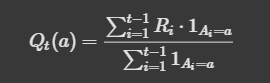

donde $\mathbb{1}_x$ es 1 si $x$ es verdad y 0 en caso contrario.


1. METODO BASICO CON PROMEDIO SIMPLE
Estados explorados: 270
Q-table (primeros 10 estados):
  0: (19, 7, 0) -> Stick: 0.572, Hit: -0.929 [Stick]
  1: (13, 8, 0) -> Stick: -0.760, Hit: -0.373 [Hit]
  2: (15, 10, 0) -> Stick: -0.599, Hit: -0.600 [Stick]
  3: (18, 10, 0) -> Stick: -0.215, Hit: -0.689 [Stick]
  4: (20, 5, 0) -> Stick: 0.643, Hit: -0.912 [Stick]
  5: (12, 10, 0) -> Stick: -0.496, Hit: -0.320 [Hit]
  6: (12, 8, 0) -> Stick: -0.395, Hit: -0.298 [Hit]
  7: (5, 5, 0) -> Stick: -0.067, Hit: 0.000 [Hit]
  8: (20, 7, 0) -> Stick: 0.779, Hit: -0.882 [Stick]
  9: (6, 10, 0) -> Stick: -0.722, Hit: 0.000 [Hit]


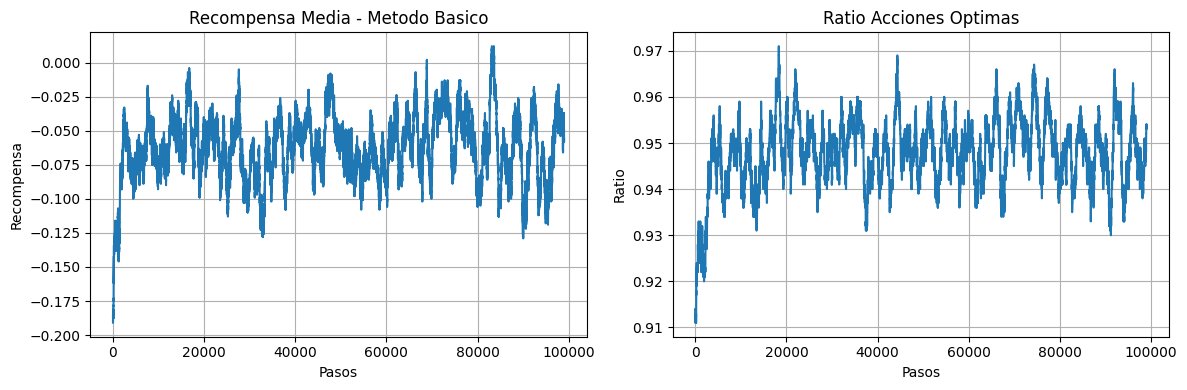

In [11]:
# =============================================================================
# TECNICA 1: METODO BASICO CON PROMEDIO SIMPLE
# =============================================================================
print("\n1. METODO BASICO CON PROMEDIO SIMPLE")
print("=" * 50)

def metodo_basico(partidas=1000, episodios=100):
    recompensas_acumuladas = defaultdict(lambda: defaultdict(list))
    recompensas_medias = []
    acciones_optimas = []
    
    for partida in range(partidas):
        for episodio in range(episodios):
            state, _ = env.reset()
            
            # Epsilon-greedy simple
            if np.random.uniform(0, 1) < 0.1:
                action = env.action_space.sample()
            else:
                # Elegir mejor accion basada en promedios actuales
                if len(recompensas_acumuladas[state][0]) == 0 and len(recompensas_acumuladas[state][1]) == 0:
                    action = env.action_space.sample()
                else:
                    avg_0 = np.mean(recompensas_acumuladas[state][0]) if recompensas_acumuladas[state][0] else 0
                    avg_1 = np.mean(recompensas_acumuladas[state][1]) if recompensas_acumuladas[state][1] else 0
                    action = 0 if avg_0 >= avg_1 else 1
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            # Acumular recompensa
            recompensas_acumuladas[state][action].append(reward)
            
            recompensas_medias.append(reward)
            
            # Verificar si es accion optima (simplificado)
            if len(recompensas_acumuladas[state][0]) > 0 and len(recompensas_acumuladas[state][1]) > 0:
                avg_0 = np.mean(recompensas_acumuladas[state][0])
                avg_1 = np.mean(recompensas_acumuladas[state][1])
                mejor_accion = 0 if avg_0 >= avg_1 else 1
                acciones_optimas.append(action == mejor_accion)
            else:
                acciones_optimas.append(True)
    
    # Convertir a Q-table
    Q = defaultdict(lambda: np.zeros(2))
    for state in recompensas_acumuladas:
        for action in [0, 1]:
            if recompensas_acumuladas[state][action]:
                Q[state][action] = np.mean(recompensas_acumuladas[state][action])
    
    return Q, recompensas_medias, acciones_optimas

Q_basico, rewards_basico, optimas_basico = metodo_basico()

print(f"Estados explorados: {len(Q_basico)}")
print("Q-table (primeros 10 estados):")
for i, (state, q_vals) in enumerate(list(Q_basico.items())[:10]):
    mejor = "Stick" if q_vals[0] >= q_vals[1] else "Hit"
    print(f"  {i}: {state} -> Stick: {q_vals[0]:.3f}, Hit: {q_vals[1]:.3f} [{mejor}]")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
window = 1000
smooth_rewards = np.convolve(rewards_basico, np.ones(window)/window, mode='valid')
plt.plot(smooth_rewards)
plt.title('Recompensa Media - Metodo Basico')
plt.xlabel('Pasos')
plt.ylabel('Recompensa')
plt.grid(True)

plt.subplot(1, 2, 2)
smooth_optimal = np.convolve(optimas_basico, np.ones(window)/window, mode='valid')
plt.plot(smooth_optimal)
plt.title('Ratio Acciones Optimas')
plt.xlabel('Pasos')
plt.ylabel('Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()


La forma más simple de escoger una acción será elegir aquella con el valor estimado más grande:

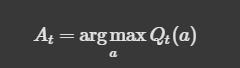

### 2. Método Epsilon-Greedy (ε-greedy)

Una alternativa para favorecer la exploración consiste en tomar acciones aleatorias de vez en cuando, con una probabilidad $\varepsilon$. Este tipo de métodos se conocen como $\varepsilon$-greedy.


2. EPSILON-GREEDY
Epsilon = 0: 270 estados explorados
Q-table (primeros 5 estados):
  0: (7, 2, 0) -> Stick: -0.010, Hit: 0.000 [Hit]
  1: (11, 10, 0) -> Stick: -0.010, Hit: 0.000 [Hit]
  2: (16, 3, 0) -> Stick: -0.477, Hit: -0.771 [Stick]
  3: (20, 7, 1) -> Stick: -0.100, Hit: 0.000 [Hit]
  4: (14, 10, 0) -> Stick: -0.800, Hit: -0.532 [Hit]
Epsilon = 0.01: 270 estados explorados
Q-table (primeros 5 estados):
  0: (14, 8, 0) -> Stick: -0.638, Hit: -0.355 [Hit]
  1: (12, 10, 0) -> Stick: -0.711, Hit: -0.563 [Hit]
  2: (14, 9, 0) -> Stick: -0.783, Hit: -0.626 [Hit]
  3: (15, 3, 0) -> Stick: 0.145, Hit: -0.758 [Stick]
  4: (15, 5, 0) -> Stick: -0.058, Hit: -0.782 [Stick]
Epsilon = 0.1: 270 estados explorados
Q-table (primeros 5 estados):
  0: (21, 7, 1) -> Stick: 1.000, Hit: 0.000 [Stick]
  1: (13, 3, 0) -> Stick: -0.254, Hit: -0.499 [Stick]
  2: (16, 3, 1) -> Stick: -0.297, Hit: 0.000 [Hit]
  3: (21, 10, 1) -> Stick: 0.880, Hit: 0.000 [Stick]
  4: (17, 10, 0) -> Stick: -0.396, Hit: -0.8

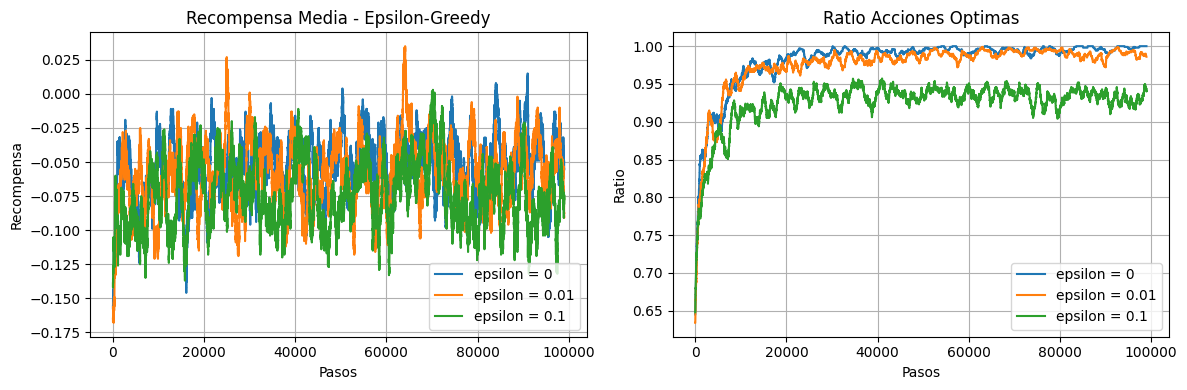

In [12]:
# =============================================================================
# TECNICA 2: EPSILON-GREEDY
# =============================================================================
print("\n2. EPSILON-GREEDY")
print("=" * 50)

def epsilon_greedy(partidas=1000, episodios=100, epsilons=[0, 0.01, 0.1]):
    resultados = {}
    
    for epsilon in epsilons:
        Q = defaultdict(lambda: np.zeros(2))
        recompensas_medias = []
        acciones_optimas = []
        alpha = 0.1
        
        for partida in range(partidas):
            for episodio in range(episodios):
                state, _ = env.reset()
                
                # Politica epsilon-greedy
                if np.random.uniform(0, 1) < epsilon:
                    action = env.action_space.sample()
                else:
                    action = np.argmax(Q[state])
                
                next_state, reward, terminated, truncated, _ = env.step(action)
                
                # Q-learning update simplificado
                Q[state][action] += alpha * (reward - Q[state][action])
                
                recompensas_medias.append(reward)
                mejor_accion = np.argmax(Q[state])
                acciones_optimas.append(action == mejor_accion)
        
        resultados[epsilon] = {
            'Q': dict(Q),
            'rewards': recompensas_medias,
            'optimal': acciones_optimas
        }
        
        print(f"Epsilon = {epsilon}: {len(Q)} estados explorados")
        print("Q-table (primeros 5 estados):")
        for i, (state, q_vals) in enumerate(list(Q.items())[:5]):
            mejor = "Stick" if q_vals[0] >= q_vals[1] else "Hit"
            print(f"  {i}: {state} -> Stick: {q_vals[0]:.3f}, Hit: {q_vals[1]:.3f} [{mejor}]")
    
    return resultados

resultados_epsilon = epsilon_greedy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
window = 1000
for eps, resultado in resultados_epsilon.items():
    smooth = np.convolve(resultado['rewards'], np.ones(window)/window, mode='valid')
    plt.plot(smooth, label=f'epsilon = {eps}')
plt.title('Recompensa Media - Epsilon-Greedy')
plt.xlabel('Pasos')
plt.ylabel('Recompensa')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for eps, resultado in resultados_epsilon.items():
    smooth = np.convolve(resultado['optimal'], np.ones(window)/window, mode='valid')
    plt.plot(smooth, label=f'epsilon = {eps}')
plt.title('Ratio Acciones Optimas')
plt.xlabel('Pasos')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

En el límite, todas las acciones serán escogidas asegurando que $Q_t(a)$ converge a $q^*(a)$. Vamos a comparar ambos métodos para diferentes valores de $\varepsilon$.

Como podemos ver, un método greedy se queda encallado con la primera acción buena que encuentra (la cual puede, o no, ser la mejor), mientras que si le dejamos explorar es posible que encuentre nuevas acciones que den como resultado mayores recompensas a largo plazo.

Un valor bajo de $\varepsilon$ converge más lento, y en este caso no tiene suficiente tiempo para descubrir la mejor acción. Una técnica muy usada consiste en ir reduciendo el valor de $\varepsilon$ durante el entrenamiento, así podemos explorar un gran espacio de acciones al principio y enfocarnos en explotar acciones buenas al final.

### 3. Implementación Incremental

Vamos a ver ahora cómo calcular los valores promedios necesarios para estimar los valores de las acciones de manera más eficiente. En la implementación anterior hemos ido guardando la recompensa obtenida al realizar cada acción, así como el número de veces que una acción se lleva a cabo para calcular el valor de la acción. Sin embargo, podemos obtener el mismo resultado con un método incremental:

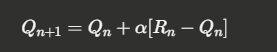

donde $\alpha \in (0,1]$ es una constante. Esta fórmula se repite a menudo en el aprendizaje por refuerzo, y generalmente la veremos en la siguiente forma:

### nuevo valor ← viejo valor + tasa de cambio[valor objetivo - viejo valor]


3. IMPLEMENTACION INCREMENTAL
Estados explorados: 270
Q-table (primeros 10 estados):
  0: (17, 6, 0) -> Stick: 0.242, Hit: -0.870 [Stick]
  1: (11, 2, 0) -> Stick: -0.990, Hit: 0.000 [Hit]
  2: (18, 9, 0) -> Stick: 0.669, Hit: -0.750 [Stick]
  3: (8, 10, 0) -> Stick: -1.000, Hit: 0.000 [Hit]
  4: (16, 2, 0) -> Stick: 0.012, Hit: -0.990 [Stick]
  5: (18, 10, 0) -> Stick: 0.283, Hit: -1.000 [Stick]
  6: (18, 7, 1) -> Stick: -0.958, Hit: 0.000 [Hit]
  7: (14, 10, 0) -> Stick: -0.997, Hit: -0.219 [Hit]
  8: (15, 10, 0) -> Stick: -0.976, Hit: -0.606 [Hit]
  9: (17, 10, 0) -> Stick: -0.481, Hit: -0.966 [Stick]


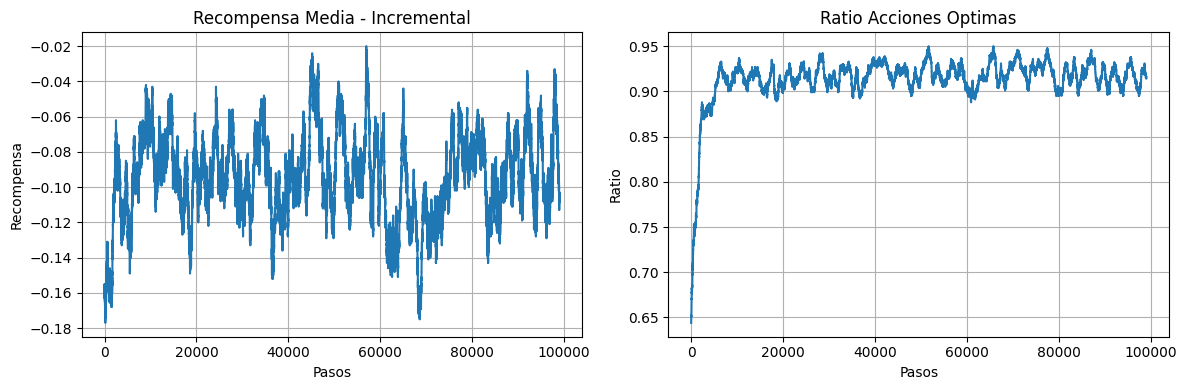

In [13]:
# =============================================================================
# TECNICA 3: IMPLEMENTACION INCREMENTAL
# =============================================================================
print("\n3. IMPLEMENTACION INCREMENTAL")
print("=" * 50)

def implementacion_incremental(partidas=1000, episodios=100, alpha=0.5):
    Q = defaultdict(lambda: np.zeros(2))
    recompensas_medias = []
    acciones_optimas = []
    epsilon = 0.1
    
    for partida in range(partidas):
        for episodio in range(episodios):
            state, _ = env.reset()
            
            # Epsilon-greedy
            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            # Actualizacion incremental: Q_n+1 = Q_n + alpha[R_n - Q_n]
            Q[state][action] += alpha * (reward - Q[state][action])
            
            recompensas_medias.append(reward)
            mejor_accion = np.argmax(Q[state])
            acciones_optimas.append(action == mejor_accion)
    
    return dict(Q), recompensas_medias, acciones_optimas

Q_incremental, rewards_incremental, optimas_incremental = implementacion_incremental()

print(f"Estados explorados: {len(Q_incremental)}")
print("Q-table (primeros 10 estados):")
for i, (state, q_vals) in enumerate(list(Q_incremental.items())[:10]):
    mejor = "Stick" if q_vals[0] >= q_vals[1] else "Hit"
    print(f"  {i}: {state} -> Stick: {q_vals[0]:.3f}, Hit: {q_vals[1]:.3f} [{mejor}]")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
window = 1000
smooth = np.convolve(rewards_incremental, np.ones(window)/window, mode='valid')
plt.plot(smooth)
plt.title('Recompensa Media - Incremental')
plt.xlabel('Pasos')
plt.ylabel('Recompensa')
plt.grid(True)

plt.subplot(1, 2, 2)
smooth = np.convolve(optimas_incremental, np.ones(window)/window, mode='valid')
plt.plot(smooth)
plt.title('Ratio Acciones Optimas')
plt.xlabel('Pasos')
plt.ylabel('Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

### 4. Valores Iniciales Optimistas
Los métodos vistos hasta ahora dependían de las estimaciones iniciales $Q_1(a)$. Esto nos introduce un bias que implica que en la práctica la inicialización se convierte en un hiperparámetro más que el usuario debe escoger. Podemos usar este hecho en nuestra ventaja.

Si inicializamos los valores de las acciones por encima de sus valores reales, nuestro agente intentará llevar a cabo estas acciones, y enseguida las descartará ya que la recompensa obtenida será menor y por lo tanto su valor disminuirá. Esto significa que incluso un agente greedy probará todas las acciones antes de quedarse con una, habiendo explorado un poco.


4. VALORES INICIALES OPTIMISTAS
Optimista: 270 estados explorados
Q-table (primeros 5 estados):
  0: (19, 5, 0) -> Stick: -0.072, Hit: -0.875 [Stick]
  1: (8, 8, 0) -> Stick: -0.125, Hit: 0.000 [Hit]
  2: (21, 4, 1) -> Stick: 1.000, Hit: 0.625 [Stick]
  3: (20, 7, 0) -> Stick: 0.996, Hit: -0.625 [Stick]
  4: (12, 10, 0) -> Stick: -0.988, Hit: -0.642 [Hit]
Normal: 270 estados explorados
Q-table (primeros 5 estados):
  0: (15, 10, 0) -> Stick: -0.999, Hit: -0.205 [Hit]
  1: (16, 5, 0) -> Stick: -0.562, Hit: -0.998 [Stick]
  2: (11, 6, 0) -> Stick: -0.304, Hit: 0.000 [Hit]
  3: (19, 10, 0) -> Stick: -0.411, Hit: -0.812 [Stick]
  4: (7, 10, 0) -> Stick: -0.999, Hit: 0.000 [Hit]


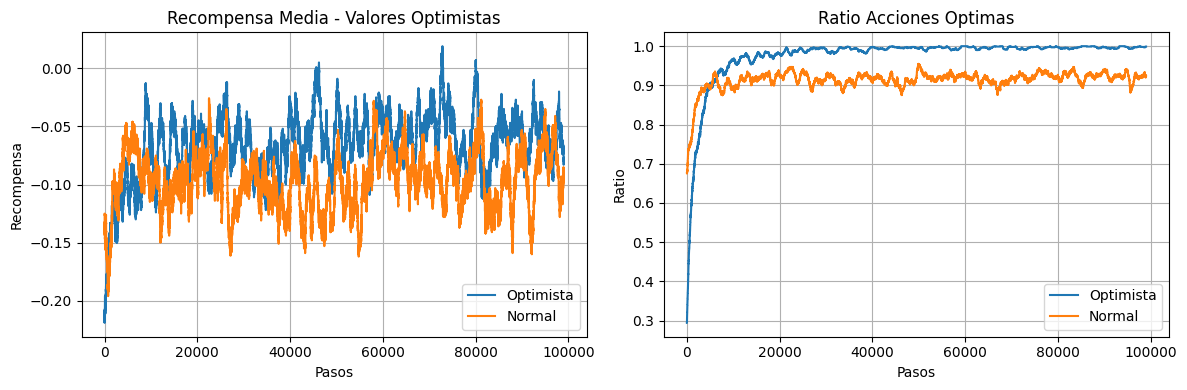

In [14]:
# =============================================================================
# TECNICA 4: VALORES INICIALES OPTIMISTAS
# =============================================================================
print("\n4. VALORES INICIALES OPTIMISTAS")
print("=" * 50)

def valores_optimistas(partidas=1000, episodios=100, alpha=0.5):
    resultados = {}
    
    for epsilon in [0, 0.1]:
        Q = defaultdict(lambda: np.array([5.0, 5.0]) if epsilon == 0 else np.array([0.0, 0.0]))
        recompensas_medias = []
        acciones_optimas = []
        
        for partida in range(partidas):
            for episodio in range(episodios):
                state, _ = env.reset()
                
                # Epsilon-greedy
                if np.random.uniform(0, 1) < epsilon:
                    action = env.action_space.sample()
                else:
                    action = np.argmax(Q[state])
                
                next_state, reward, terminated, truncated, _ = env.step(action)
                
                # Actualizacion incremental
                Q[state][action] += alpha * (reward - Q[state][action])
                
                recompensas_medias.append(reward)
                mejor_accion = np.argmax(Q[state])
                acciones_optimas.append(action == mejor_accion)
        
        label = "Optimista" if epsilon == 0 else "Normal"
        resultados[label] = {
            'Q': dict(Q),
            'rewards': recompensas_medias,
            'optimal': acciones_optimas
        }
        
        print(f"{label}: {len(Q)} estados explorados")
        print("Q-table (primeros 5 estados):")
        for i, (state, q_vals) in enumerate(list(Q.items())[:5]):
            mejor = "Stick" if q_vals[0] >= q_vals[1] else "Hit"
            print(f"  {i}: {state} -> Stick: {q_vals[0]:.3f}, Hit: {q_vals[1]:.3f} [{mejor}]")
    
    return resultados

resultados_optimistas = valores_optimistas()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
window = 1000
for label, resultado in resultados_optimistas.items():
    smooth = np.convolve(resultado['rewards'], np.ones(window)/window, mode='valid')
    plt.plot(smooth, label=label)
plt.title('Recompensa Media - Valores Optimistas')
plt.xlabel('Pasos')
plt.ylabel('Recompensa')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for label, resultado in resultados_optimistas.items():
    smooth = np.convolve(resultado['optimal'], np.ones(window)/window, mode='valid')
    plt.plot(smooth, label=label)
plt.title('Ratio Acciones Optimas')
plt.xlabel('Pasos')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Ahora, nuestro agente greedy explora todas las acciones antes de elegir la mejor, la cual explota hasta el final. Esta técnica funciona bien en problemas estacionarios, pero si el problema no es estacionario y las recompensas van cambiando durante el tiempo tendremos el mismo problema que antes con un agente que no explora.

### 5. Upper Confidence Bound (UCB)

El método $\varepsilon$-greedy basa la exploración en escoger acciones aleatorias sin ningún tipo de preferencia, pero una mejor forma de hacerlo es escogiendo aquellas acciones menos exploradas con mayor potencial.

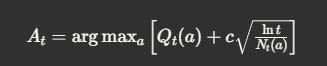

donde $\ln t$ es el logaritmo natural de $t$, $N_t(a)$ es el número de veces que se ha efectuado la acción $a$ y $c > 0$ es una constante que controla el ratio de exploración.


5. UPPER CONFIDENCE BOUND (UCB)
Estados explorados: 270
Q-table (primeros 10 estados):
  0: (13, 7, 0) -> Stick: -0.711, Hit: -0.305 [Hit]
  1: (17, 7, 1) -> Stick: -0.429, Hit: 0.000 [Hit]
  2: (10, 10, 0) -> Stick: -0.815, Hit: 0.000 [Hit]
  3: (11, 6, 0) -> Stick: -0.473, Hit: 0.000 [Hit]
  4: (15, 5, 0) -> Stick: -0.107, Hit: -0.694 [Stick]
  5: (17, 6, 0) -> Stick: -0.006, Hit: -0.747 [Stick]
  6: (14, 2, 0) -> Stick: -0.298, Hit: -0.738 [Stick]
  7: (15, 2, 0) -> Stick: -0.742, Hit: -0.545 [Hit]
  8: (15, 10, 0) -> Stick: -0.959, Hit: -0.847 [Hit]
  9: (20, 3, 0) -> Stick: 0.776, Hit: -0.848 [Stick]


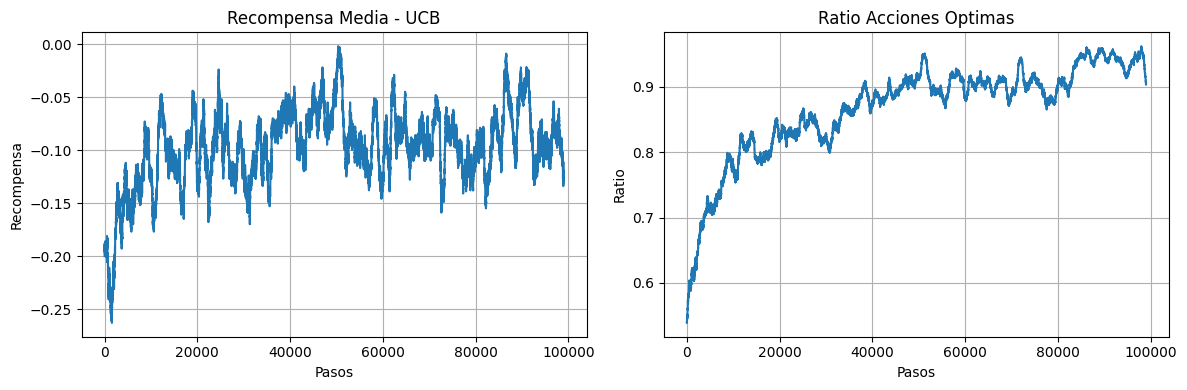

In [15]:
# =============================================================================
# TECNICA 5: UPPER CONFIDENCE BOUND (UCB)
# =============================================================================
print("\n5. UPPER CONFIDENCE BOUND (UCB)")
print("=" * 50)

def ucb_method(partidas=1000, episodios=100, c=2):
    Q = defaultdict(lambda: np.zeros(2))
    N = defaultdict(lambda: np.ones(2))  # Contadores
    recompensas_medias = []
    acciones_optimas = []
    alpha = 0.1
    t = 0
    
    for partida in range(partidas):
        for episodio in range(episodios):
            state, _ = env.reset()
            t += 1
            
            # Seleccion UCB
            if t <= 10:
                action = t % 2
            else:
                ucb_values = Q[state] + c * np.sqrt(np.log(t) / N[state])
                action = np.argmax(ucb_values)
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            # Actualizar contadores y Q-values
            N[state][action] += 1
            Q[state][action] += alpha * (reward - Q[state][action])
            
            recompensas_medias.append(reward)
            mejor_accion = np.argmax(Q[state])
            acciones_optimas.append(action == mejor_accion)
    
    return dict(Q), recompensas_medias, acciones_optimas

Q_ucb, rewards_ucb, optimas_ucb = ucb_method()

print(f"Estados explorados: {len(Q_ucb)}")
print("Q-table (primeros 10 estados):")
for i, (state, q_vals) in enumerate(list(Q_ucb.items())[:10]):
    mejor = "Stick" if q_vals[0] >= q_vals[1] else "Hit"
    print(f"  {i}: {state} -> Stick: {q_vals[0]:.3f}, Hit: {q_vals[1]:.3f} [{mejor}]")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
window = 1000
smooth = np.convolve(rewards_ucb, np.ones(window)/window, mode='valid')
plt.plot(smooth)
plt.title('Recompensa Media - UCB')
plt.xlabel('Pasos')
plt.ylabel('Recompensa')
plt.grid(True)

plt.subplot(1, 2, 2)
smooth = np.convolve(optimas_ucb, np.ones(window)/window, mode='valid')
plt.plot(smooth)
plt.title('Ratio Acciones Optimas')
plt.xlabel('Pasos')
plt.ylabel('Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()


Si bien esta técnica funciona mejor para este problema, su uso no está muy generalizado ya que no es fácil de integrar en problemas de aprendizaje por refuerzo con grandes espacios de búsqueda o problemas no estacionarios.

### 6. Algoritmos de Gradiente
Hasta el momento solo hemos considerado métodos que estiman el valor de las acciones y utilizan estas estimaciones para seleccionar la acción que ejecutar en cada momento. Sin embargo, existen otras alternativas, como asignar una preferencia a cada acción $H_t(a)$. Cuanta mayor sea la preferencia de una acción, más veces será ejecutada.

Podemos definir $\pi_t(a)$ como la probabilidad de escoger la acción $a$ en el instante $t$:

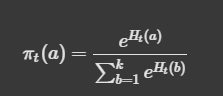

Existe un algoritmo para entrenar un agente bajo estas condiciones basado en la idea de ascenso por gradiente:


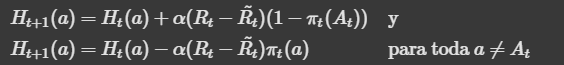

donde $\bar{R}_t$ es el promedio de todas las recompensas hasta el instante $t$ (incluido). Este valor actúa como referencia con la que comparamos la recompensa. Si es mayor, la probabilidad de escoger esa acción en el futuro aumenta. Si es menor, la probabilidad se reduce. Las acciones no escogidas se actualizan en el sentido opuesto.


6. ALGORITMOS DE GRADIENTE
Alpha = 0.1: 270 estados explorados
Tabla de preferencias (primeros 5 estados):
  0: (19, 2, 0)
      H: Stick=1.233, Hit=-1.233
      π: Stick=0.922, Hit=0.078 [Stick]
  1: (10, 10, 0)
      H: Stick=-1.920, Hit=1.920
      π: Stick=0.021, Hit=0.979 [Hit]
  2: (8, 6, 0)
      H: Stick=-0.880, Hit=0.880
      π: Stick=0.147, Hit=0.853 [Hit]
  3: (11, 7, 0)
      H: Stick=-0.757, Hit=0.757
      π: Stick=0.180, Hit=0.820 [Hit]
  4: (15, 8, 0)
      H: Stick=-0.233, Hit=0.233
      π: Stick=0.386, Hit=0.614 [Hit]
Alpha = 0.4: 270 estados explorados
Tabla de preferencias (primeros 5 estados):
  0: (20, 3, 1)
      H: Stick=1.364, Hit=-1.364
      π: Stick=0.939, Hit=0.061 [Stick]
  1: (10, 8, 0)
      H: Stick=-1.407, Hit=1.407
      π: Stick=0.057, Hit=0.943 [Hit]
  2: (14, 6, 0)
      H: Stick=1.741, Hit=-1.741
      π: Stick=0.970, Hit=0.030 [Stick]
  3: (16, 7, 0)
      H: Stick=2.039, Hit=-2.039
      π: Stick=0.983, Hit=0.017 [Stick]
  4: (15, 5, 0)
     

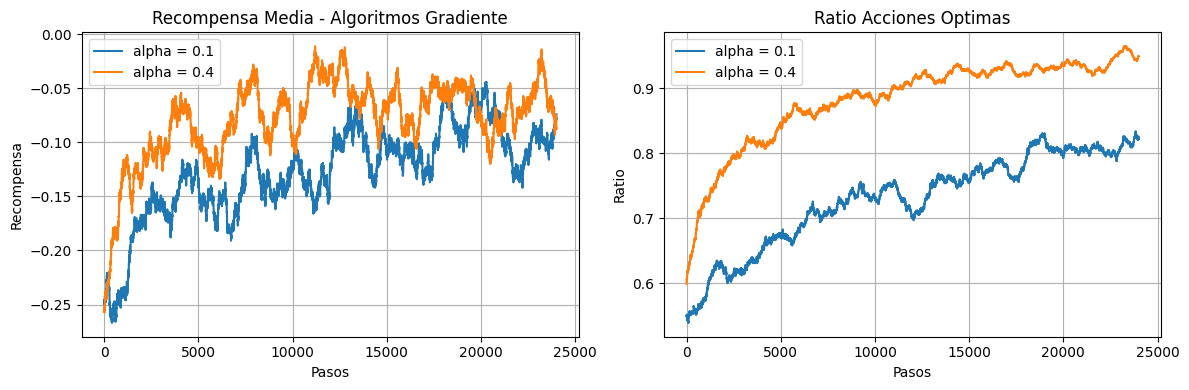

In [16]:
# =============================================================================
# TECNICA 6: ALGORITMOS DE GRADIENTE
# =============================================================================
print("\n6. ALGORITMOS DE GRADIENTE")
print("=" * 50)

def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x)

def algoritmos_gradiente(partidas=500, episodios=50, alphas=[0.1, 0.4]):
    resultados = {}
    
    for alpha in alphas:
        H = defaultdict(lambda: np.zeros(2))  # Preferencias
        recompensas_todas = []
        recompensas_medias = []
        acciones_optimas = []
        
        for partida in range(partidas):
            for episodio in range(episodios):
                state, _ = env.reset()
                
                # Calcular probabilidades usando softmax
                pi = softmax(H[state])
                
                # Seleccionar accion segun probabilidades
                action = np.random.choice(2, p=pi)
                
                next_state, reward, terminated, truncated, _ = env.step(action)
                
                # Calcular baseline
                recompensas_todas.append(reward)
                baseline = np.mean(recompensas_todas[-1000:])  # Ventana deslizante
                
                # Actualizar preferencias
                for a in range(2):
                    if a == action:
                        H[state][a] += alpha * (reward - baseline) * (1 - pi[a])
                    else:
                        H[state][a] -= alpha * (reward - baseline) * pi[a]
                
                recompensas_medias.append(reward)
                mejor_accion = np.argmax(pi)
                acciones_optimas.append(action == mejor_accion)
        
        resultados[alpha] = {
            'H': dict(H),
            'rewards': recompensas_medias,
            'optimal': acciones_optimas
        }
        
        print(f"Alpha = {alpha}: {len(H)} estados explorados")
        print("Tabla de preferencias (primeros 5 estados):")
        for i, (state, prefs) in enumerate(list(H.items())[:5]):
            pi = softmax(prefs)
            mejor = "Stick" if pi[0] >= pi[1] else "Hit"
            print(f"  {i}: {state}")
            print(f"      H: Stick={prefs[0]:.3f}, Hit={prefs[1]:.3f}")
            print(f"      π: Stick={pi[0]:.3f}, Hit={pi[1]:.3f} [{mejor}]")
    
    return resultados

resultados_gradiente = algoritmos_gradiente()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
window = 1000
for alpha, resultado in resultados_gradiente.items():
    smooth = np.convolve(resultado['rewards'], np.ones(window)/window, mode='valid')
    plt.plot(smooth, label=f'alpha = {alpha}')
plt.title('Recompensa Media - Algoritmos Gradiente')
plt.xlabel('Pasos')
plt.ylabel('Recompensa')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for alpha, resultado in resultados_gradiente.items():
    smooth = np.convolve(resultado['optimal'], np.ones(window)/window, mode='valid')
    plt.plot(smooth, label=f'alpha = {alpha}')
plt.title('Ratio Acciones Optimas')
plt.xlabel('Pasos')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Búsqueda Asociativa

En el ejemplo ilustrado en este notebook hemos tratado con una tarea no asociativa. En este tipo de tareas no es necesario asociar diferentes acciones a diferentes situaciones. Sin embargo, en una tarea de aprendizaje por refuerzo general existen multitud de situaciones en las que podemos llevar a cabo la misma acción, con diferente resultado en cada caso, y el objetivo será el de aprender una política: una relación entre situaciones y las mejores acciones que llevar a cabo en esa situación.

Aún así, seguiremos necesitando de prueba y error para encontrar las mejores acciones y poder asociarlas a las situaciones correspondientes, para lo cual aplicaremos los conceptos vistos aquí.

## Comparación de Resultados


7. COMPARACION DE TODAS LAS TECNICAS


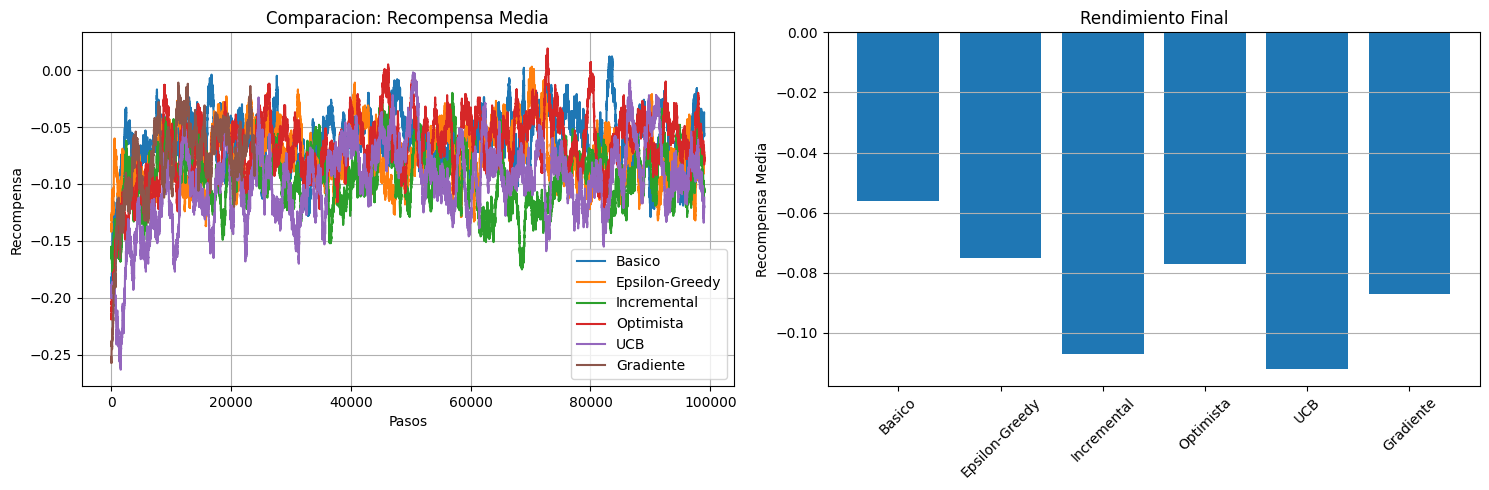


RENDIMIENTO FINAL:
Basico: -0.0560
Epsilon-Greedy: -0.0750
Incremental: -0.1070
Optimista: -0.0770
UCB: -0.1120
Gradiente: -0.0870

MEJOR METODO: Basico
Rendimiento: -0.0560


In [17]:
# =============================================================================
# COMPARACION FINAL
# =============================================================================
print("\n7. COMPARACION DE TODAS LAS TECNICAS")
print("=" * 50)

todos_resultados = {
    'Basico': rewards_basico,
    'Epsilon-Greedy': resultados_epsilon[0.1]['rewards'],
    'Incremental': rewards_incremental,
    'Optimista': resultados_optimistas['Optimista']['rewards'],
    'UCB': rewards_ucb,
    'Gradiente': resultados_gradiente[0.4]['rewards']
}

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
window = 1000
for metodo, rewards in todos_resultados.items():
    smooth = np.convolve(rewards, np.ones(window)/window, mode='valid')
    plt.plot(smooth, label=metodo)
plt.title('Comparacion: Recompensa Media')
plt.xlabel('Pasos')
plt.ylabel('Recompensa')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
rendimiento_final = {}
for metodo, rewards in todos_resultados.items():
    rendimiento_final[metodo] = np.mean(rewards[-1000:])

metodos = list(rendimiento_final.keys())
valores = list(rendimiento_final.values())
plt.bar(metodos, valores)
plt.title('Rendimiento Final')
plt.ylabel('Recompensa Media')
plt.xticks(rotation=45)
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

print("\nRENDIMIENTO FINAL:")
for metodo, valor in rendimiento_final.items():
    print(f"{metodo}: {valor:.4f}")

mejor_metodo = max(rendimiento_final, key=rendimiento_final.get)
print(f"\nMEJOR METODO: {mejor_metodo}")
print(f"Rendimiento: {rendimiento_final[mejor_metodo]:.4f}")


### Resumen
En este notebook hemos visto ejemplos sencillos para balancear la exploración y la explotación aplicados al entorno BlackJack de Gymnasium:

1. Algoritmos ε-greedy que escogen acciones aleatorias de vez en cuando
2. Algoritmos UCB que favorecen en cada instante acciones que han sido ejecutadas pocas veces
3. Algoritmos de gradiente que no estiman valores, sino preferencias, y favorecen aquellas acciones más probables utilizando una distribución softmax
4. Valores iniciales optimistas que pueden favorecer la exploración en un método greedy
5. Implementación incremental que actualiza eficientemente los valores de acción

También hemos visto brevemente cómo la inicialización puede favorecer la exploración en un método greedy. La eficacia de usar un valor de $\varepsilon$ u otro dependerá del caso, es un hiperparámetro más a optimizar. En casos con una varianza en las recompensas elevada necesitaremos más exploración, por lo que podemos esperar todavía mejor resultado que sin exploración.

El estudio de estos métodos fundamentales proporciona una base sólida para entender problemas más complejos de aprendizaje por refuerzo donde tendremos que aprender políticas que asocien estados con acciones óptimas.